# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


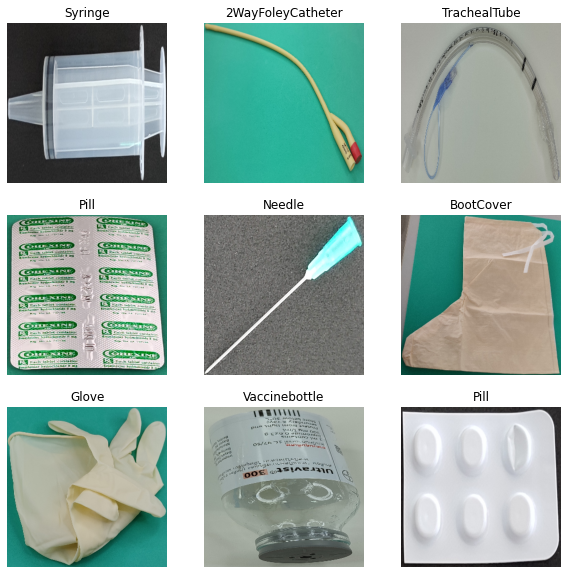

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(23, 299, 299, 3)
(23,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)


## Freez Extractor+

In [18]:
custom_inceptionv3_model.trainable = False
for layer in custom_inceptionv3_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
tf.keras.utils.plot_model(custom_inceptionv3_model, to_file="InceptionRemoveOutput.png", show_shapes=True)

In [20]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
#DeepDense
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 41)                5289      
Total params: 22,365,513
Trainable params: 562,729
Non-trainable params: 21,802,784
_________________________________________________________________


In [22]:
class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

5


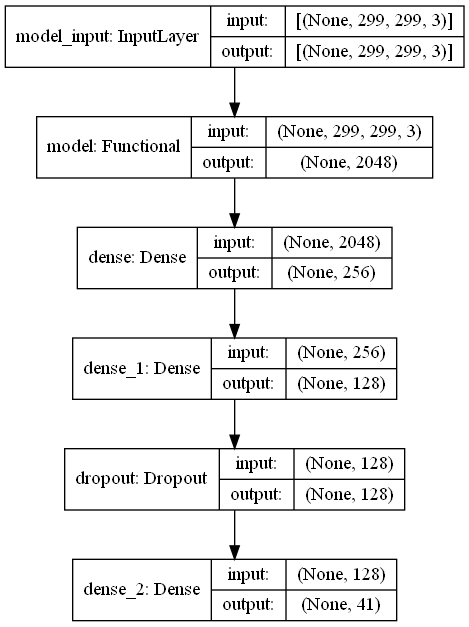

In [23]:
#model.layers[-1]._name = 'Classifier'
#model.layers[-2]._name = 'InceptionV3'
print(len(model.layers))
tf.keras.utils.plot_model(model, to_file="Incepv3_FreezExtractorOurOutputLayer.png", show_shapes=True)

# Fitting

In [1]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_DeepDense256-128-NoClassImbalanced-NoAug-NormalLR/'

In [25]:
EPOCHS = 2000
save_model_interval = 40
checkpoint_filepath = path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch{epoch:04d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/2000
49/49 [==============================] - 44s 336ms/step - loss: 1.8003 - accuracy: 0.5409 - val_loss: 0.9666 - val_accuracy: 0.6947
Epoch 2/2000
49/49 [==============================] - 9s 187ms/step - loss: 0.7280 - accuracy: 0.7874 - val_loss: 0.5104 - val_accuracy: 0.8461
Epoch 3/2000
49/49 [==============================] - 9s 187ms/step - loss: 0.3970 - accuracy: 0.8795 - val_loss: 0.3387 - val_accuracy: 0.8913
Epoch 4/2000
49/49 [==============================] - 9s 187ms/step - loss: 0.2748 - accuracy: 0.9199 - val_loss: 0.2852 - val_accuracy: 0.8952
Epoch 5/2000
49/49 [==============================] - 9s 187ms/step - loss: 0.1774 - accuracy: 0.9519 - val_loss: 0.2430 - val_accuracy: 0.9276
Epoch 6/2000
49/49 [==============================] - 9s 188ms/step - loss: 0.1294 - accuracy: 0.9648 - val_loss: 0.2032 - val_accuracy: 0.9379
Epoch 7/2000
49/49 [==============================] - 9s 188ms/step - loss: 0.1032 - accuracy: 0.9735 - val_loss: 0.1794 - val_accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

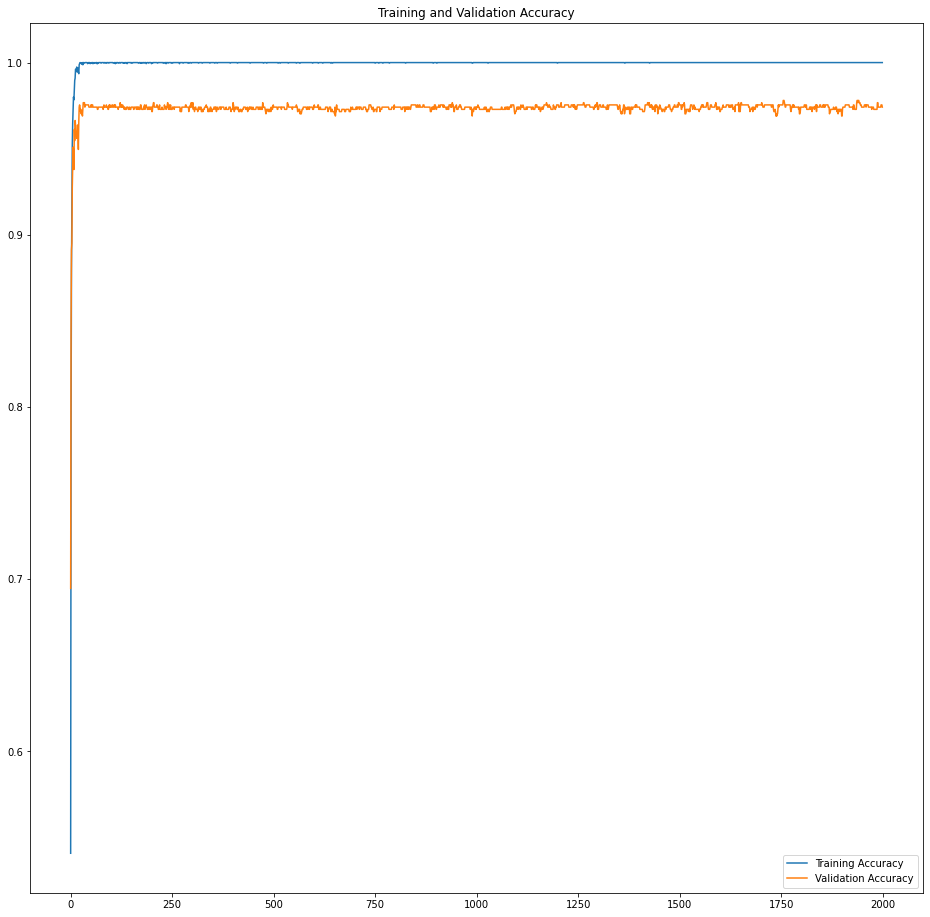

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


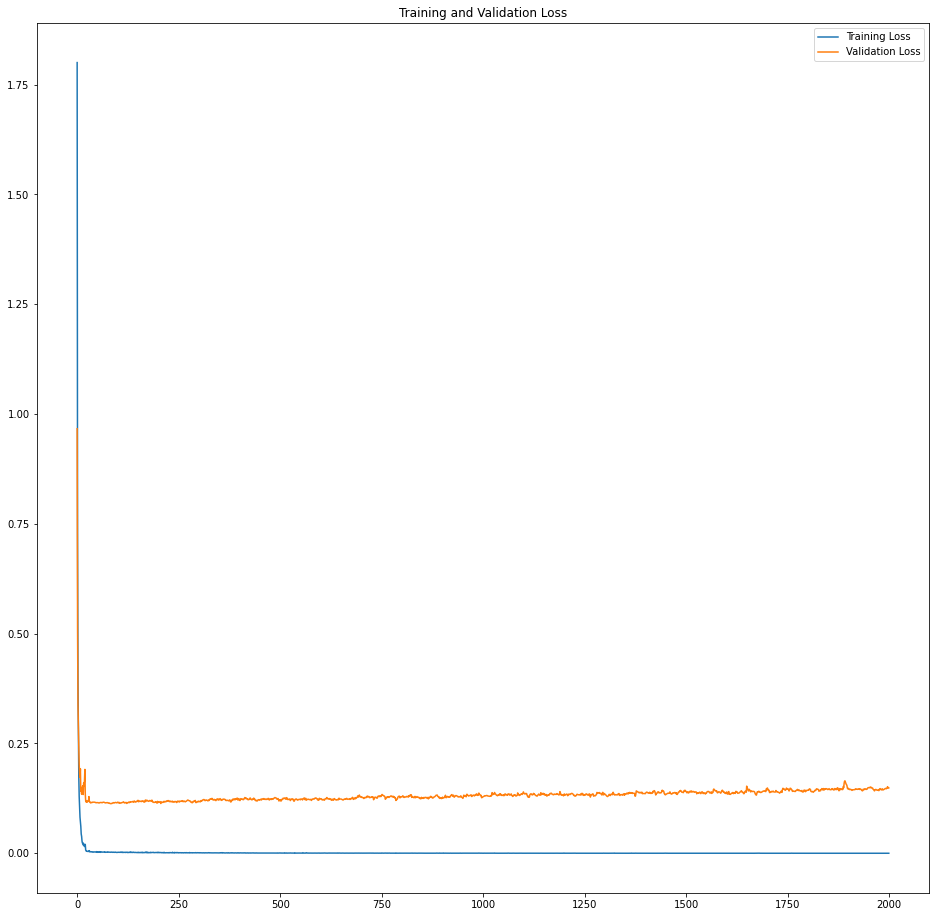

In [27]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 347ms/step - loss: 0.8782 - accuracy: 0.8233
test_indoor_ds_results:test loss, test acc: [0.8781521916389465, 0.8232998847961426]


In [29]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 26s 440ms/step - loss: 2.2160 - accuracy: 0.7350
test_outdoor_ds_results:test loss, test acc: [2.2159910202026367, 0.7350318431854248]


In [30]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 8s 203ms/step - loss: 2.5183 - accuracy: 0.6872
test_belt_ds_results:test loss, test acc: [2.5183310508728027, 0.6872166991233826]


In [31]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_DeepDense256-128-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0040-val_acc0.98.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_DeepDense256-128-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0080-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_DeepDense256-128-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0120-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_DeepDense256-128-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0160-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_DeepDense256-128-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0200-val_acc0.97.pb',
 'D:/ModelMedicalWas

# Testing in testset

In [32]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 140ms/step - loss: 1.7947 - accuracy: 0.6804
Epoch040 
 test_indoor_acc=0.8199554085731506 
 test_outdoor_acc=0.7375796437263489 
 test_belt_acc=0.6804170608520508
35/35 [==============================] - 5s 143ms/step - loss: 1.8213 - accuracy: 0.6759
Epoch080 
 test_indoor_acc=0.8160535097122192 
 test_outdoor_acc=0.7328025698661804 
 test_belt_acc=0.675883948802948
35/35 [==============================] - 5s 142ms/step - loss: 1.8516 - accuracy: 0.6759
Epoch120 
 test_indoor_acc=0.8199554085731506 
 test_outdoor_acc=0.7353503108024597 
 test_belt_acc=0.675883948802948
35/35 [==============================] - 5s 140ms/step - loss: 1.8754 - accuracy: 0.6768
Epoch160 
 test_indoor_acc=0.8171683549880981 
 test_outdoor_acc=0.737261176109314 
 test_belt_acc=0.6767905950546265
35/35 [==============================] - 5s 139ms/step - loss: 1.8549 - accuracy: 0.6800
Epoch200 
 test_indoor_acc=0.8255295157432556 
 test_outdoor_acc=0.734713375568389

In [33]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)
    

range(40, 2040, 40)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

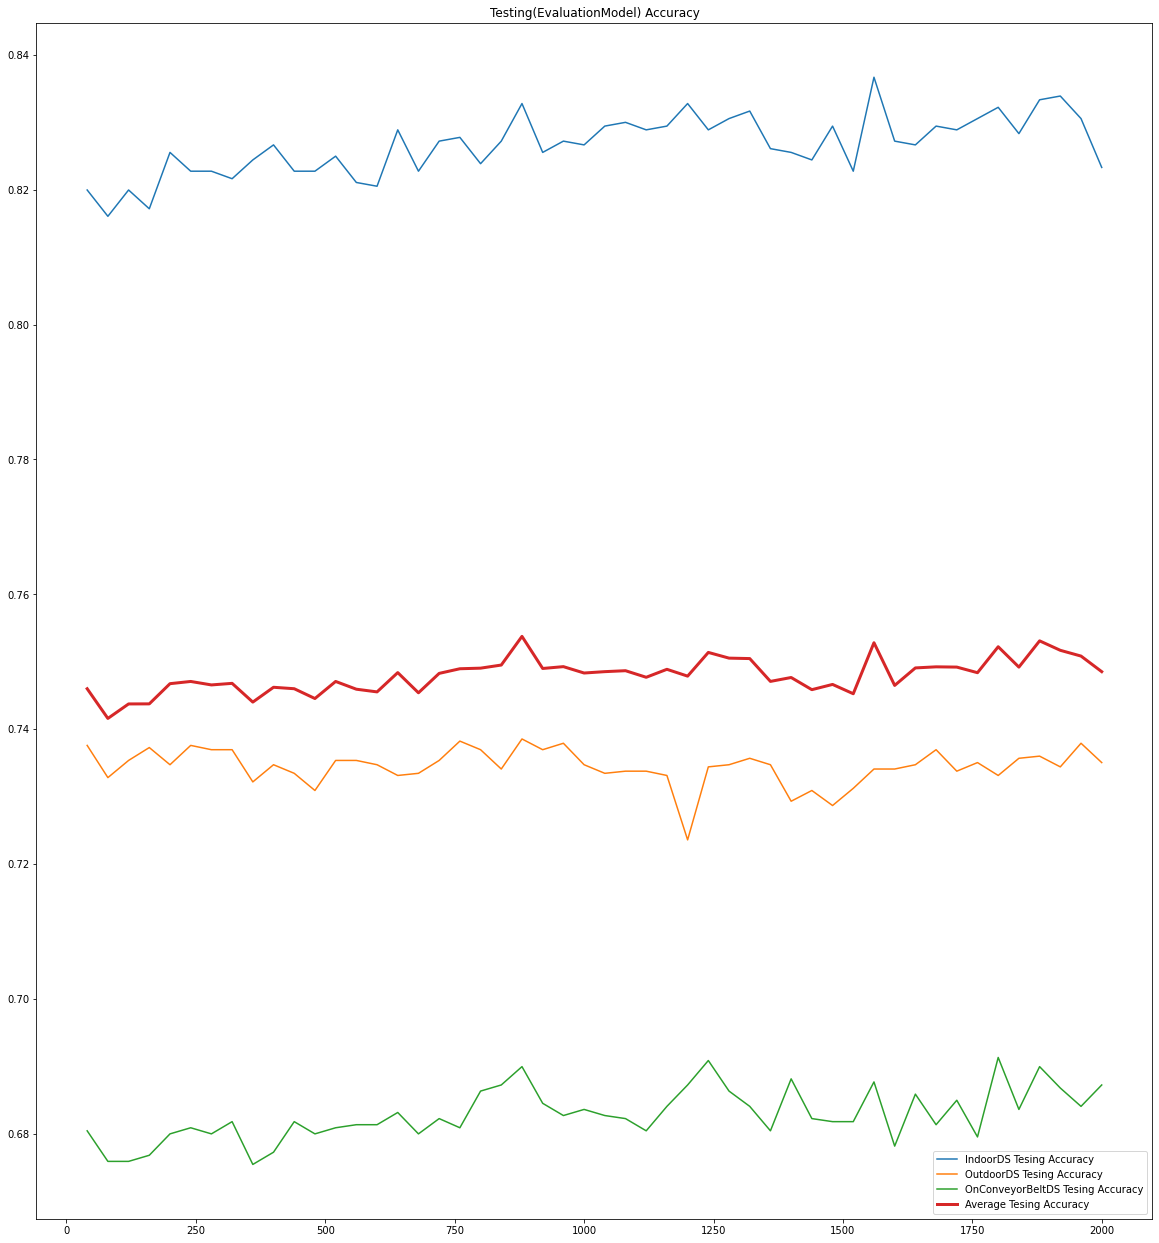

In [34]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

In [35]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.753749152024587
max index -> 21
The [Epoch] of max acc -> 880


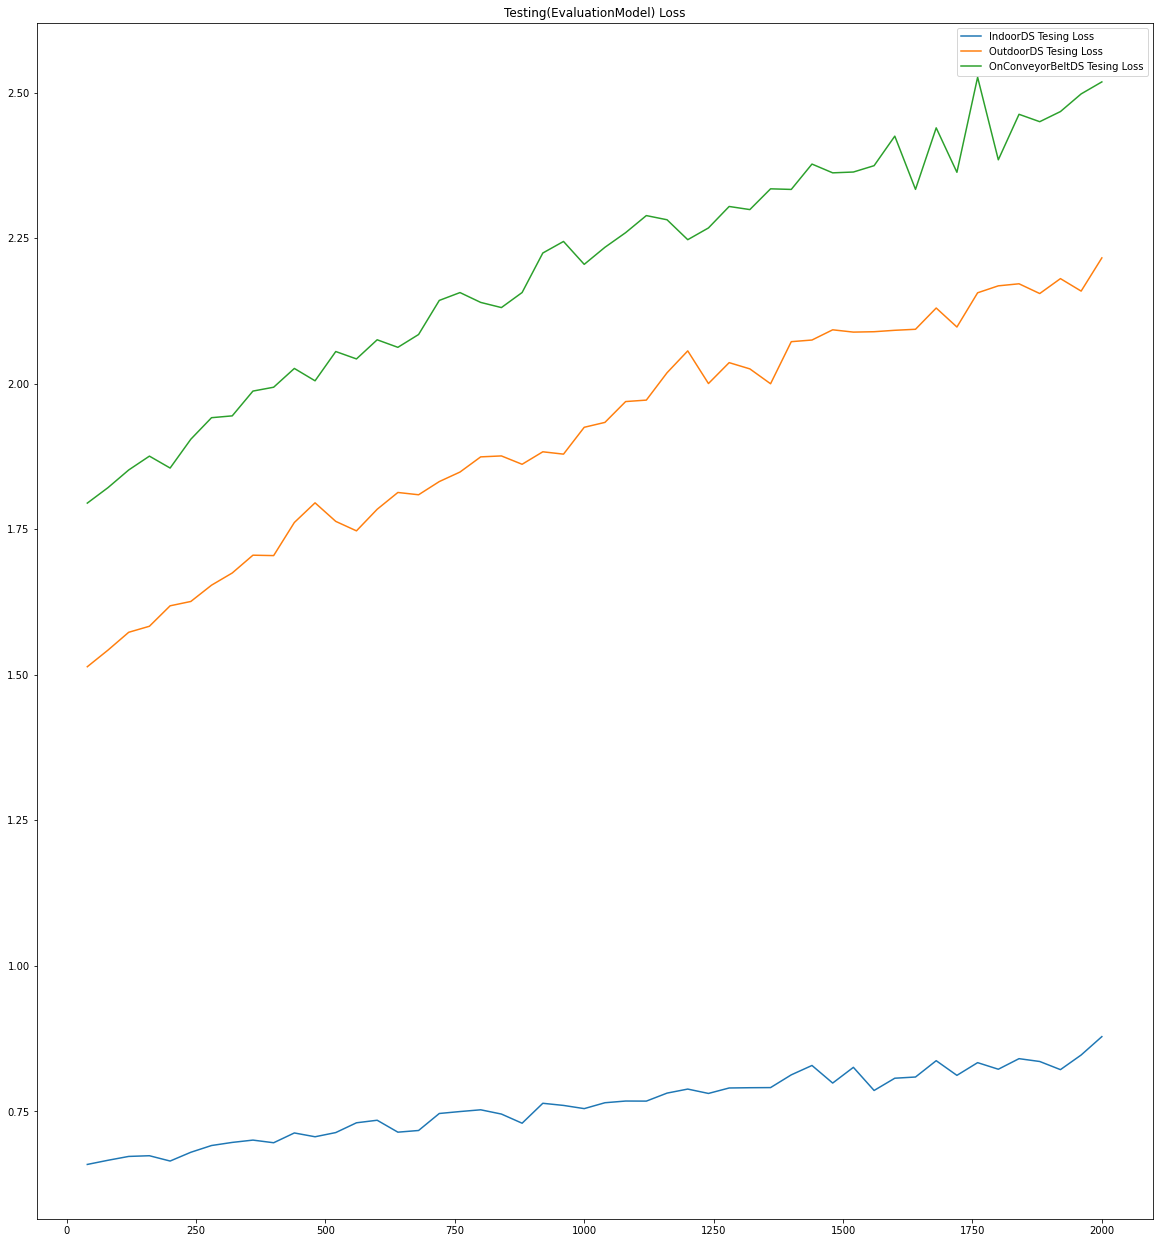

In [36]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [37]:
test_indoor_acc

[0.8199554085731506,
 0.8160535097122192,
 0.8199554085731506,
 0.8171683549880981,
 0.8255295157432556,
 0.8227424621582031,
 0.8227424621582031,
 0.821627676486969,
 0.8244147300720215,
 0.8266443610191345,
 0.8227424621582031,
 0.8227424621582031,
 0.8249721527099609,
 0.8210702538490295,
 0.8205128312110901,
 0.8288740515708923,
 0.8227424621582031,
 0.827201783657074,
 0.8277592062950134,
 0.823857307434082,
 0.827201783657074,
 0.832775890827179,
 0.8255295157432556,
 0.827201783657074,
 0.8266443610191345,
 0.829431414604187,
 0.8299888372421265,
 0.8288740515708923,
 0.829431414604187,
 0.832775890827179,
 0.8288740515708923,
 0.8305462598800659,
 0.8316611051559448,
 0.8260869383811951,
 0.8255295157432556,
 0.8244147300720215,
 0.829431414604187,
 0.8227424621582031,
 0.8366777896881104,
 0.827201783657074,
 0.8266443610191345,
 0.829431414604187,
 0.8288740515708923,
 0.8305462598800659,
 0.8322185277938843,
 0.8283166289329529,
 0.8333333134651184,
 0.8338907361030579,
 0.8

In [38]:
test_outdoor_acc

[0.7375796437263489,
 0.7328025698661804,
 0.7353503108024597,
 0.737261176109314,
 0.7347133755683899,
 0.7375796437263489,
 0.7369426488876343,
 0.7369426488876343,
 0.7321656346321106,
 0.7347133755683899,
 0.7334395051002502,
 0.7308917045593262,
 0.7353503108024597,
 0.7353503108024597,
 0.7347133755683899,
 0.7331210374832153,
 0.7334395051002502,
 0.7353503108024597,
 0.7382165789604187,
 0.7369426488876343,
 0.7340764403343201,
 0.7385350465774536,
 0.7369426488876343,
 0.7378981113433838,
 0.7347133755683899,
 0.7334395051002502,
 0.7337579727172852,
 0.7337579727172852,
 0.7331210374832153,
 0.7235668897628784,
 0.734394907951355,
 0.7347133755683899,
 0.7356687784194946,
 0.7347133755683899,
 0.7292993664741516,
 0.7308917045593262,
 0.7286624312400818,
 0.7312101721763611,
 0.7340764403343201,
 0.7340764403343201,
 0.7347133755683899,
 0.7369426488876343,
 0.7337579727172852,
 0.7350318431854248,
 0.7331210374832153,
 0.7356687784194946,
 0.7359872460365295,
 0.734394907951

In [39]:
test_belt_acc

[0.6804170608520508,
 0.675883948802948,
 0.675883948802948,
 0.6767905950546265,
 0.6799637079238892,
 0.6808703541755676,
 0.6799637079238892,
 0.6817770004272461,
 0.6754306554794312,
 0.6772438883781433,
 0.6817770004272461,
 0.6799637079238892,
 0.6808703541755676,
 0.6813236474990845,
 0.6813236474990845,
 0.6831368803977966,
 0.6799637079238892,
 0.6822302937507629,
 0.6808703541755676,
 0.6863100528717041,
 0.6872166991233826,
 0.6899365186691284,
 0.6844968199729919,
 0.6826835870742798,
 0.6835902333259583,
 0.6826835870742798,
 0.6822302937507629,
 0.6804170608520508,
 0.6840435266494751,
 0.6872166991233826,
 0.6908431649208069,
 0.6863100528717041,
 0.6840435266494751,
 0.6804170608520508,
 0.6881232857704163,
 0.6822302937507629,
 0.6817770004272461,
 0.6817770004272461,
 0.6876699924468994,
 0.678150475025177,
 0.6858567595481873,
 0.6813236474990845,
 0.6849501132965088,
 0.6795104146003723,
 0.6912964582443237,
 0.6835902333259583,
 0.6899365186691284,
 0.6867633461952

In [40]:
test_indoor_loss

[0.6585703492164612,
 0.6657300591468811,
 0.6723403930664062,
 0.6735278964042664,
 0.6644086241722107,
 0.6794765591621399,
 0.6910802125930786,
 0.6964097023010254,
 0.7003840208053589,
 0.6958330869674683,
 0.712662398815155,
 0.7061179876327515,
 0.7133313417434692,
 0.7301182746887207,
 0.7344964146614075,
 0.7140104174613953,
 0.7169002294540405,
 0.7461094856262207,
 0.7494379878044128,
 0.7524494528770447,
 0.7451300621032715,
 0.7293912172317505,
 0.7636318206787109,
 0.7599570751190186,
 0.7544670701026917,
 0.7645701169967651,
 0.7674912810325623,
 0.7673614621162415,
 0.7811077833175659,
 0.7880488038063049,
 0.7805406451225281,
 0.7899205088615417,
 0.7903749942779541,
 0.7905924320220947,
 0.8124866485595703,
 0.8286015391349792,
 0.7983864545822144,
 0.82538902759552,
 0.7856455445289612,
 0.8066995739936829,
 0.8087570667266846,
 0.8367940783500671,
 0.8116210103034973,
 0.8334469795227051,
 0.8221341371536255,
 0.8402873873710632,
 0.8354308009147644,
 0.8214375972747

In [41]:
test_outdoor_loss

[1.513613224029541,
 1.5421959161758423,
 1.5728009939193726,
 1.583144187927246,
 1.6182814836502075,
 1.625736951828003,
 1.6537290811538696,
 1.6746617555618286,
 1.7052350044250488,
 1.704525351524353,
 1.761413812637329,
 1.7951844930648804,
 1.7632968425750732,
 1.7470431327819824,
 1.784127950668335,
 1.8129825592041016,
 1.8090498447418213,
 1.831701636314392,
 1.848074197769165,
 1.8741422891616821,
 1.875764012336731,
 1.8614189624786377,
 1.8828585147857666,
 1.8788312673568726,
 1.9249593019485474,
 1.9333685636520386,
 1.9691541194915771,
 1.9716531038284302,
 2.018657922744751,
 2.0562140941619873,
 2.0001285076141357,
 2.036020278930664,
 2.025289535522461,
 1.999748706817627,
 2.0720410346984863,
 2.074876546859741,
 2.0924227237701416,
 2.088479995727539,
 2.0891478061676025,
 2.0915980339050293,
 2.093341112136841,
 2.1298635005950928,
 2.097231864929199,
 2.156022548675537,
 2.16797137260437,
 2.171492099761963,
 2.154740333557129,
 2.180366039276123,
 2.158941745758

In [42]:
test_belt_loss

[1.794699788093567,
 1.82129967212677,
 1.8516395092010498,
 1.8754141330718994,
 1.8549402952194214,
 1.9044746160507202,
 1.94144868850708,
 1.9445827007293701,
 1.9871667623519897,
 1.9937931299209595,
 2.026052474975586,
 2.0048248767852783,
 2.0551135540008545,
 2.0424137115478516,
 2.075289726257324,
 2.0623250007629395,
 2.084350109100342,
 2.142911195755005,
 2.1564085483551025,
 2.139486312866211,
 2.1306264400482178,
 2.1564834117889404,
 2.2243573665618896,
 2.2442190647125244,
 2.2048819065093994,
 2.234177827835083,
 2.259331703186035,
 2.2886593341827393,
 2.281477212905884,
 2.2472405433654785,
 2.2674336433410645,
 2.3043136596679688,
 2.2989730834960938,
 2.33463454246521,
 2.3336076736450195,
 2.3771655559539795,
 2.3620944023132324,
 2.3634960651397705,
 2.3744051456451416,
 2.4251465797424316,
 2.333719253540039,
 2.43937087059021,
 2.363037109375,
 2.5263326168060303,
 2.3845102787017822,
 2.4626636505126953,
 2.449968099594116,
 2.4673638343811035,
 2.497693538665

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
from numba import cuda
cuda.select_device(0)
cuda.close()

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0880-val_acc0.97.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [4]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=5335
FP=1805
acc=0.7471988795518207
all check = 7140


In [5]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 81.03448275862068%
2WayConnectorforFoley acc = 82.99319727891157%
2WayFoleyCatheter acc = 60.447761194029844%
3WayConnectorforFoley acc = 94.01709401709401%
3Waystopcock acc = 98.1981981981982%
AlcoholBottle acc = 86.25%
AlcoholPad acc = 41.269841269841265%
BootCover acc = 69.87951807228916%
CottonBall acc = 74.25149700598801%
CottonSwap acc = 76.22377622377621%
Dilator acc = 71.7948717948718%
DisposableInfusionSet acc = 50.442477876106196%
ExtensionTube acc = 20.32520325203252%
FaceShield acc = 66.66666666666666%
FrontLoadSyringe acc = 67.2566371681416%
GauzePad acc = 58.52272727272727%
Glove acc = 72.91666666666666%
GuideWire acc = 29.464285714285715%
LiquidBottle acc = 65.2671755725191%
Mask acc = 94.02597402597402%
NGTube acc = 36.12903225806451%
NasalCannula acc = 65.48672566371681%
Needle acc = 83.21428571428572%
OxygenMask acc = 97.74436090225564%
PPESuit acc = 93.54838709677419%
PharmaceuticalProduct acc = 62.616822429906534%
Pill acc = 96.9187675070

In [6]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 94,   0,   0, ...,   0,   0,   0],
       [  2, 122,   0, ...,   0,   0,   0],
       [  0,   0,  81, ...,   0,   1,  16],
       ...,
       [  0,   0,   0, ...,  80,   1,   1],
       [  0,   0,   0, ...,   1, 184,   2],
       [  0,   0,   0, ...,   1,   1,  78]], dtype=int64)

In [7]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[81.03448276,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.36054422, 82.99319728,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 60.44776119, ...,  0.        ,
         0.74626866, 11.94029851],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 66.66666667,
         0.83333333,  0.83333333],
       [ 0.        ,  0.        ,  0.        , ...,  0.46948357,
        86.38497653,  0.93896714],
       [ 0.        ,  0.        ,  0.        , ...,  0.87719298,
         0.87719298, 68.42105263]])

<AxesSubplot:>

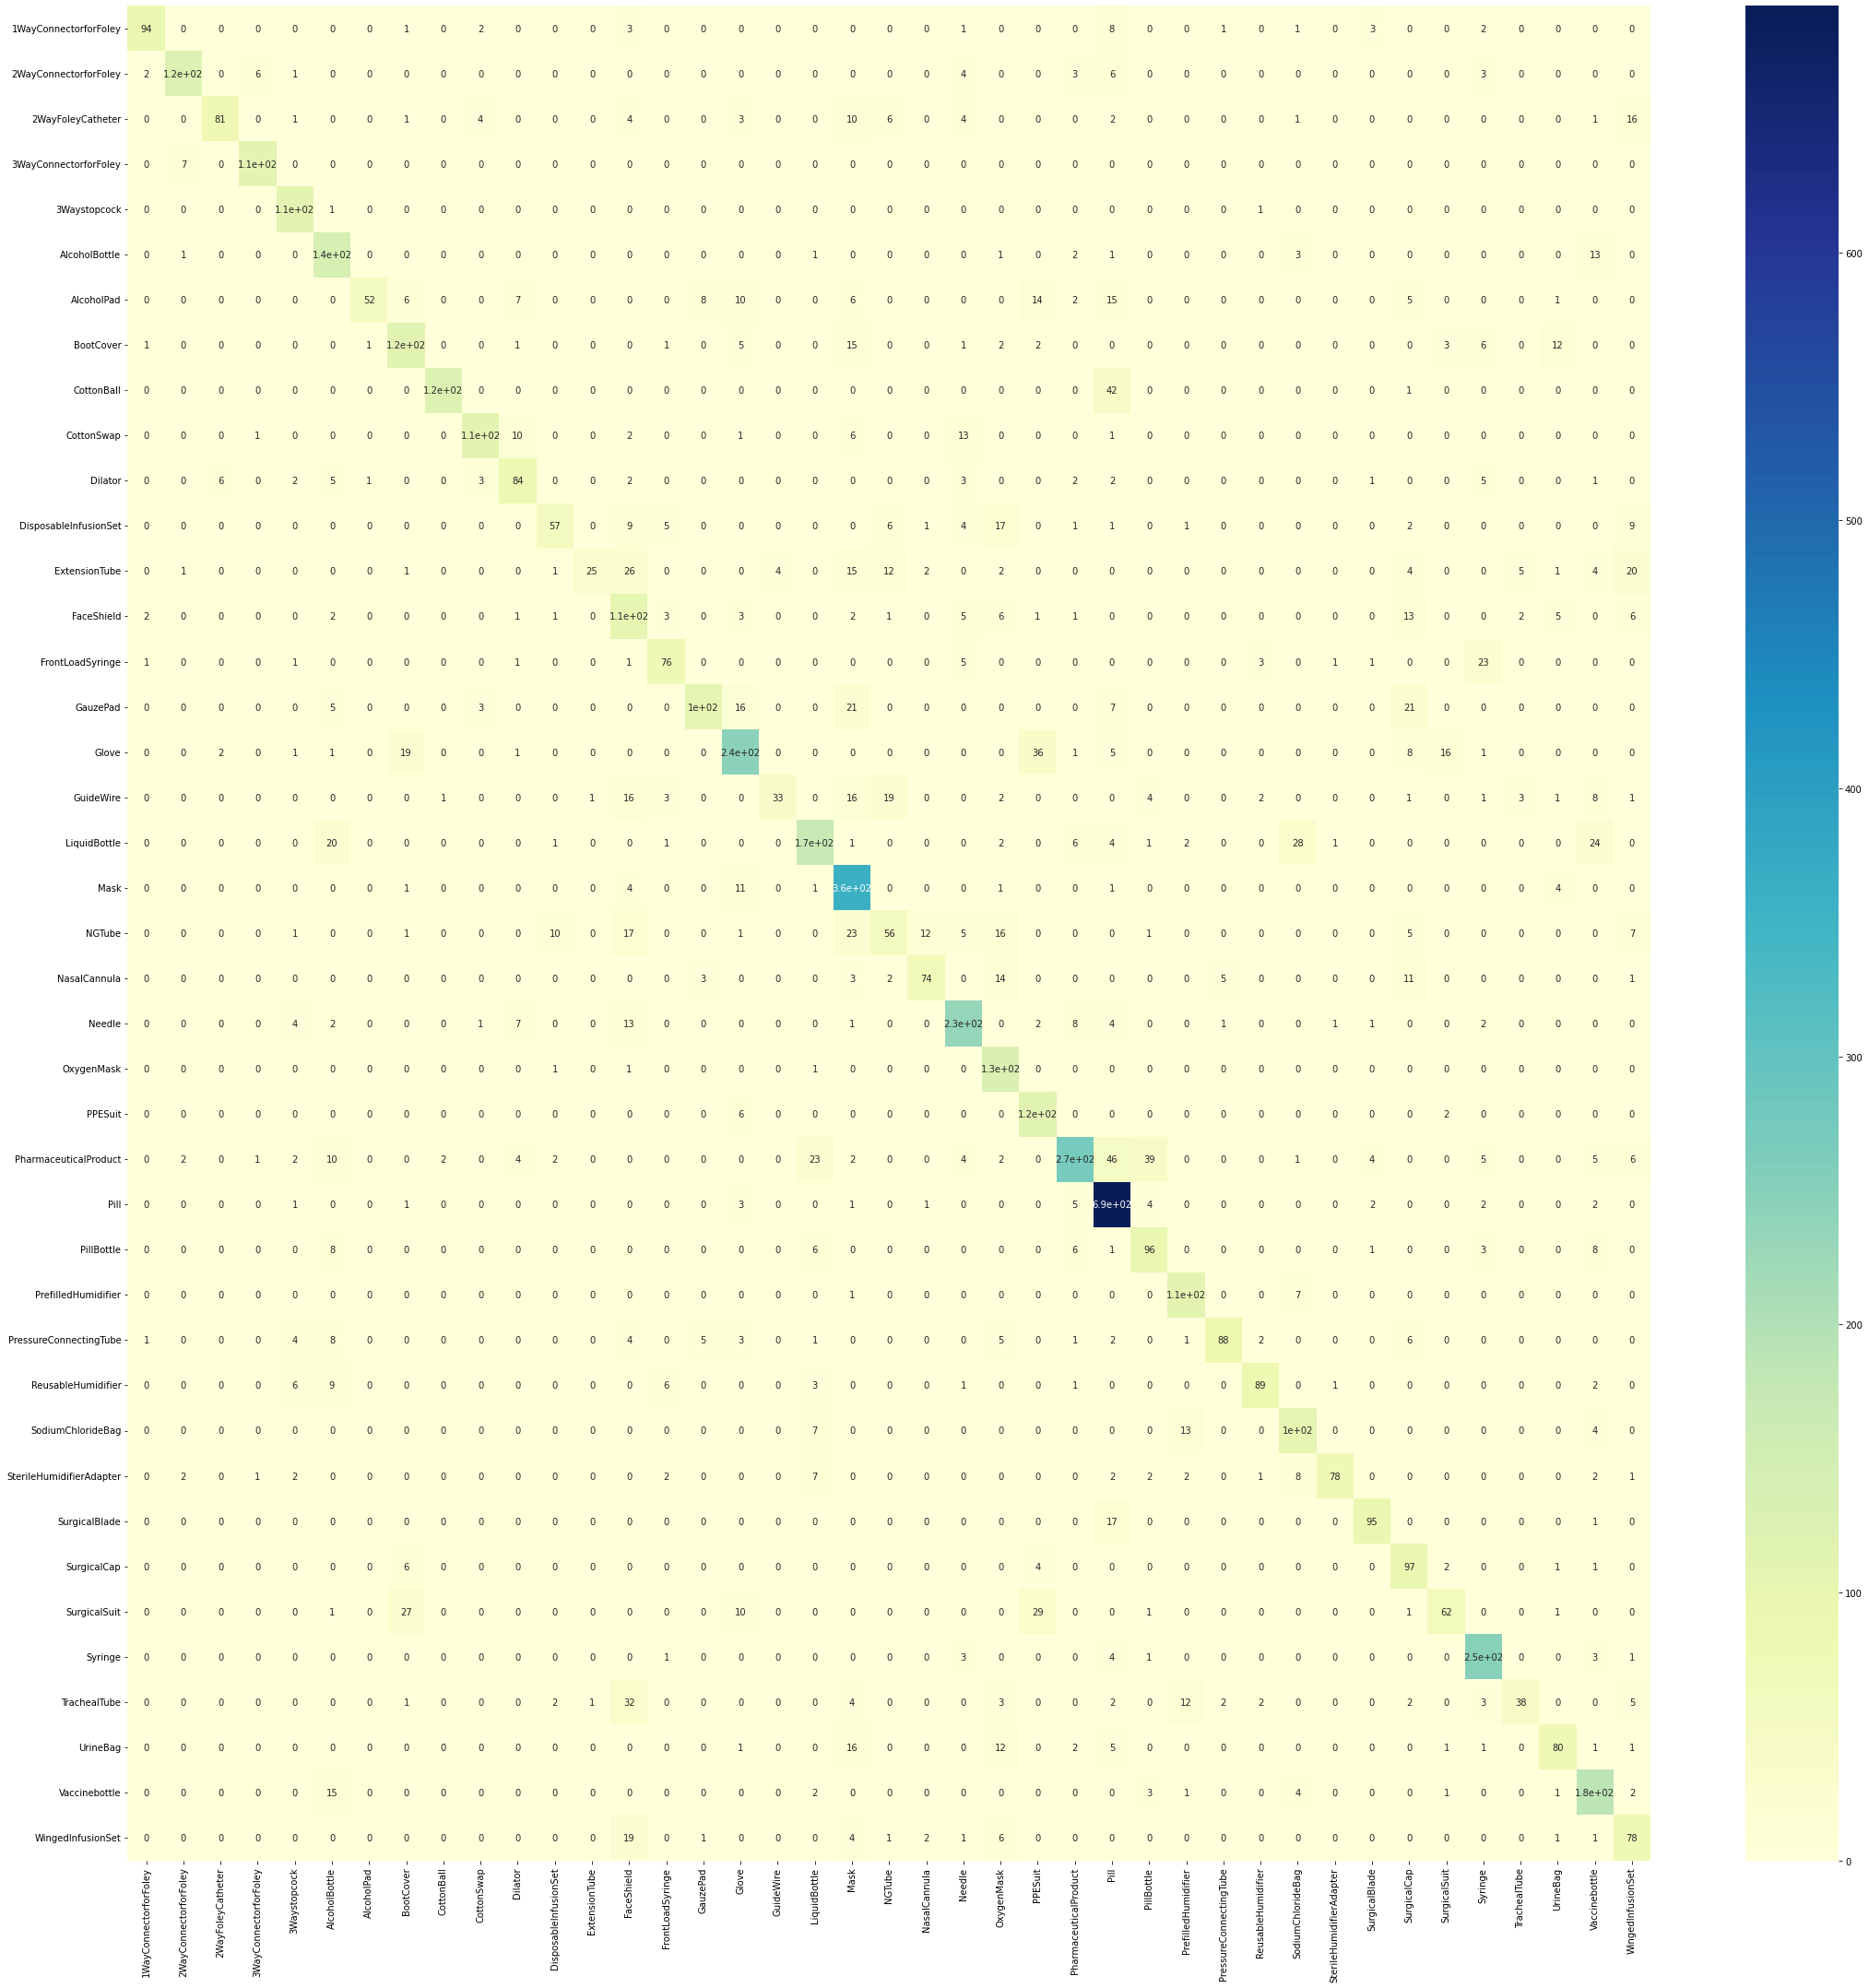

In [8]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

<AxesSubplot:>

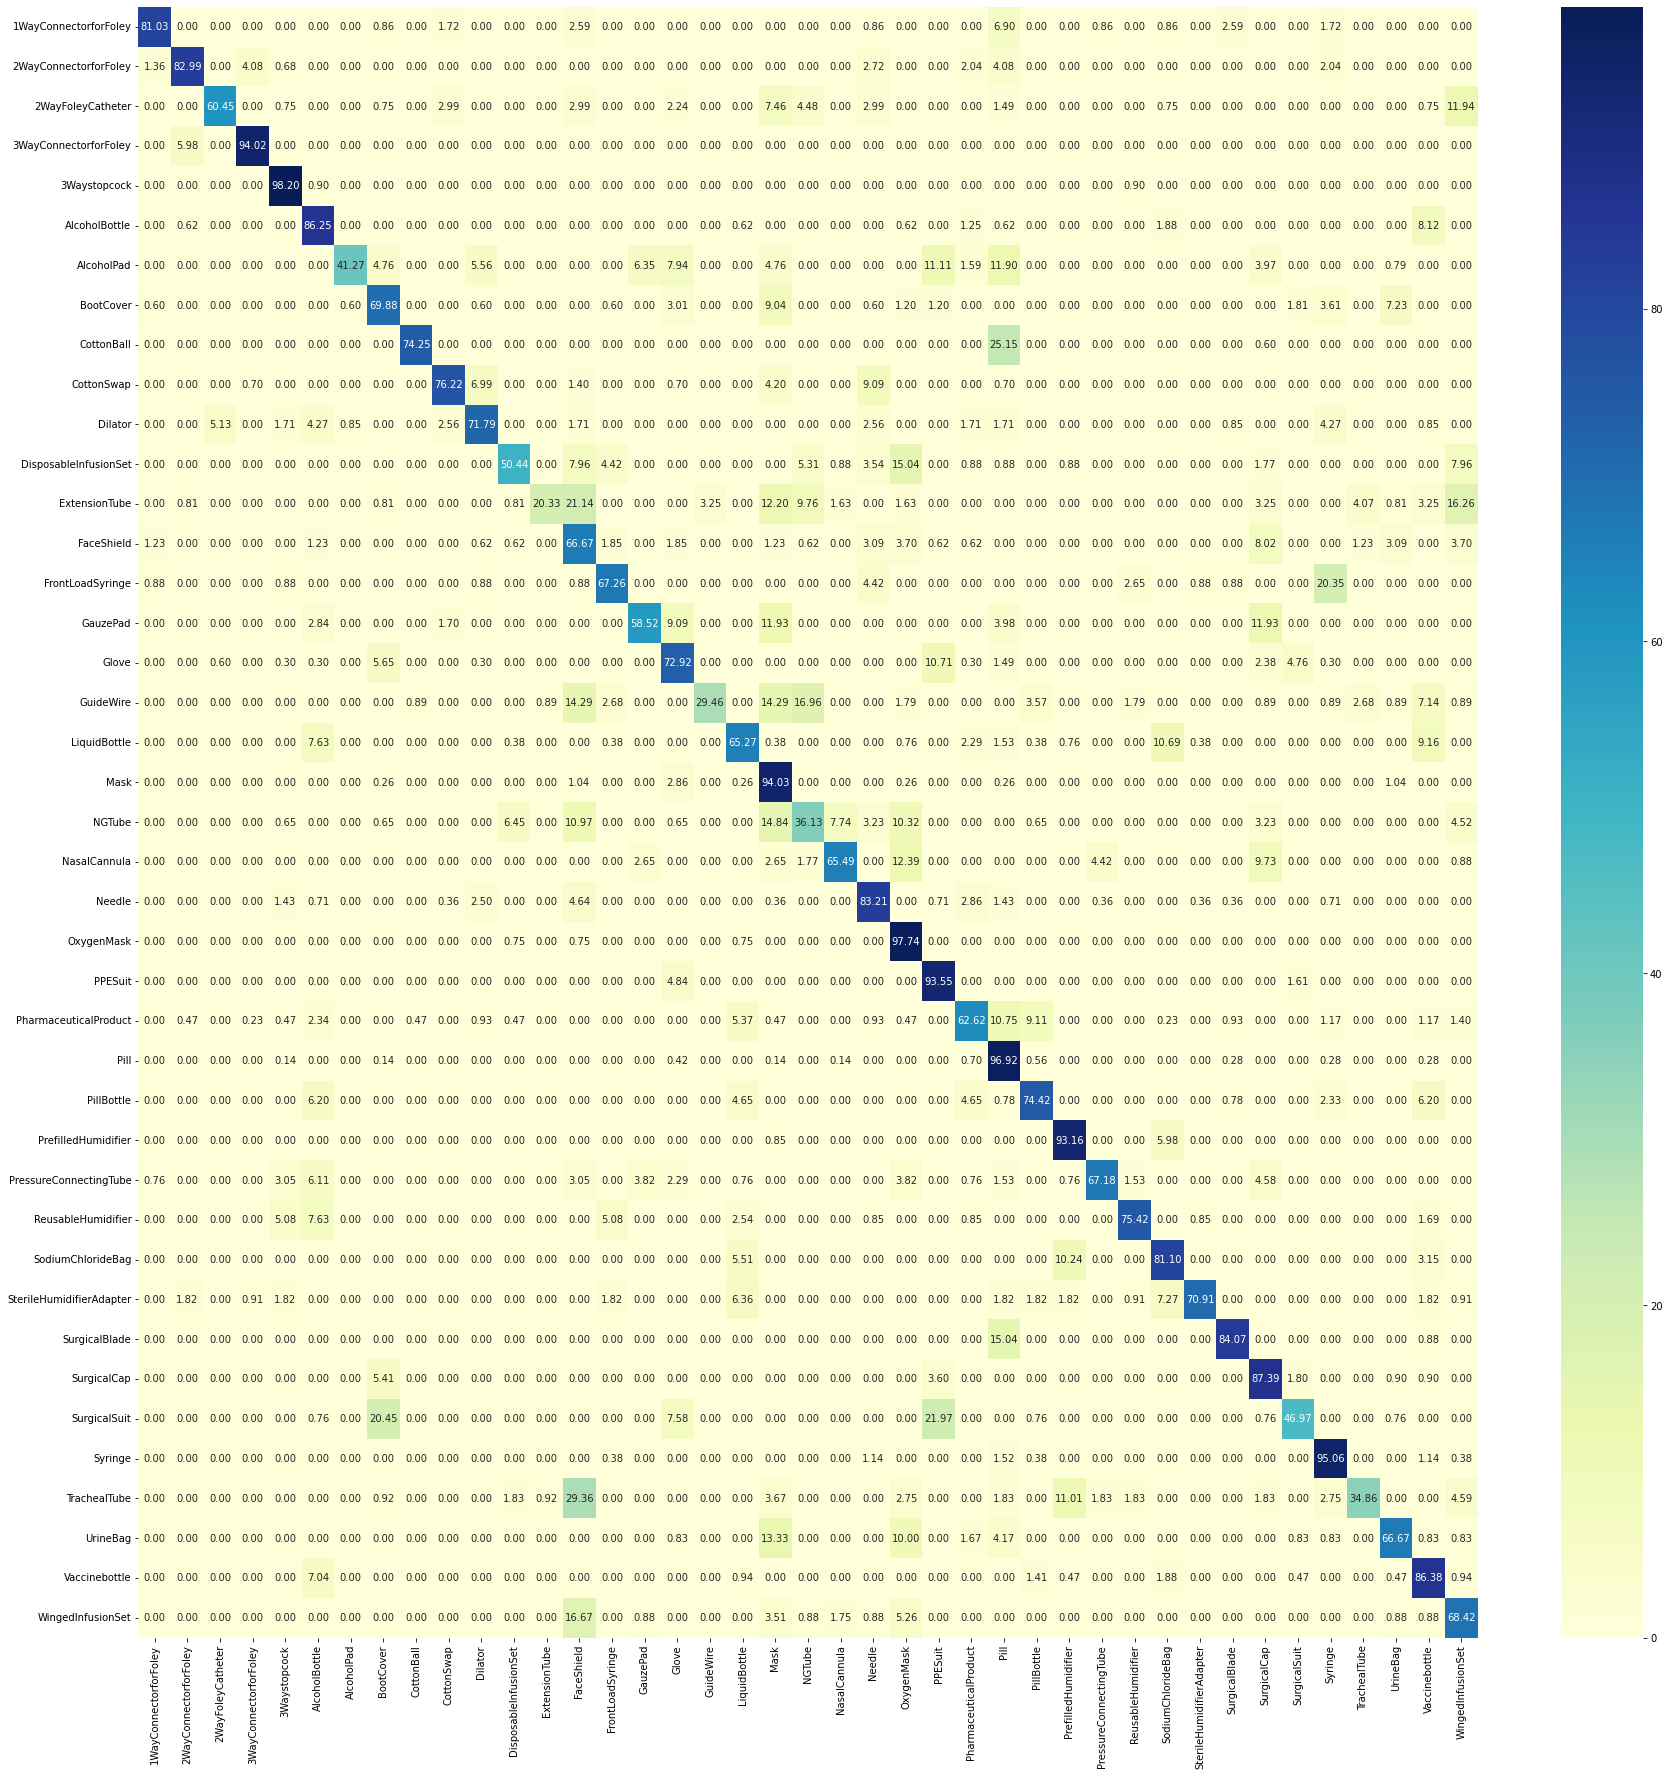

In [11]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt=".2f")